In [22]:
import os

import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

from fragpara2vec.Mol2vec import generate_corpus_from_smiles
# from fragpara2vec.Parallel2vec 

In [3]:
frag2num_tree_decom = pd.read_csv('../../big_data/03_fragment/frag2count_with_UNK.csv')
frag2num_tree_decom.head(2)

,fragment,n_fragment
0,CC,230715285
1,CO,93883927


In [4]:
frag2num_fingerprint = pd.read_csv('../../big_data/04_model_Mol2vec/Mol2vec_frag_id2num.csv')
frag2num_fingerprint.head(2)

,Unnamed: 0,n_fragment
0,2246728737,29964741
1,3542456614,5118844


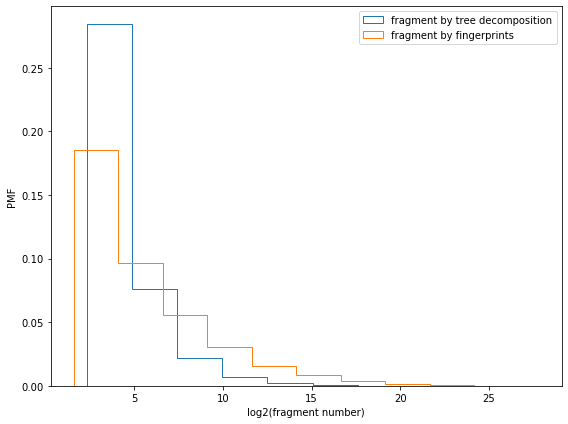

In [8]:
plt.figure(figsize=(8, 6))
plt.hist(np.log2(frag2num_tree_decom['n_fragment']), density=True, histtype='step', label='fragment by tree decomposition')
plt.hist(np.log2(frag2num_fingerprint['n_fragment']), density=True, histtype='step', label='fragment by fingerprints')
plt.xlabel('log2(fragment number)')
plt.ylabel('PMF')
plt.legend()
plt.tight_layout()
plt.savefig('n_fragment_pmf.png', dpi=200)

In [9]:
frag2num_tree_decom['frag_len'] = frag2num_tree_decom['fragment'].map(lambda x: len(x))

In [10]:
frag2num_tree_decom.head(2)

,fragment,n_fragment,frag_len
0,CC,230715285,2
1,CO,93883927,2


(array([2.4910e+03, 2.8565e+04, 4.4915e+04, 2.9376e+04, 1.2513e+04,
        3.6960e+03, 1.1080e+03, 5.0900e+02, 1.2500e+02, 1.4000e+01]),
 array([ 1., 10., 19., 28., 37., 46., 55., 64., 73., 82., 91.]),
 <a list of 10 Patch objects>)

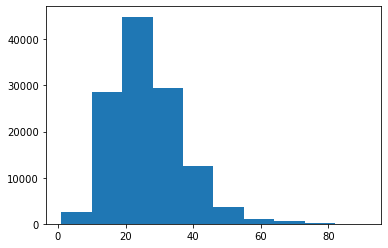

In [11]:
plt.hist(frag2num_tree_decom['frag_len'])

In [13]:
# count ring molecules
selected_3classes = pd.read_csv('../../big_data/09_evaluate_model/selected_3classes.txt', sep='\t', index_col=0)
selected_3classes.head()

,md_class
cid,
3493774,110001011
18954759,110001011
28446672,110001011
2796299,110001011
3229243,110001011


In [14]:
selected_cid2smiles = pd.read_csv('../../big_data/08_train_mol_vec_by_mlp/selected_cid2smiles.csv', index_col=0)
selected_cid2smiles.head(2)

,smiles
cid,
21413939,CCCCCCCCCCCCCCC(CC(C(CO)O)O)OCCC
21811787,CCCCCCCCCCCC(C(CCCCCCCCCCC)OCCO)OCCO


In [19]:
cid2smiles_3class = selected_cid2smiles.loc[selected_3classes.index, :].copy()
cid2smiles_3class.shape
cid2smiles_3class.to_csv('./cid2smiles_3class.csv')

In [21]:
generate_corpus_from_smiles(in_file='cid2smiles_3class.csv', out_file='cid2sentence_Mol2vec.txt', n_jobs=4, keep_cid=True, r=1)

2059it [00:00, 686983.69it/s]
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


>>> the number of unique cid is 2058
>>> the number of all cid is 2058


[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    6.2s


% molecules successfully processed.


[Parallel(n_jobs=4)]: Done 2058 out of 2058 | elapsed:    6.4s finished


In [28]:
for frag_type in ['parallel', 'tandem']:
    print('deal with {}'.format(frag_type))
    cid2sentence_file_path = os.path.join('../../big_data/03_fragment/{}_cid2smiles_sentence.csv'.format(frag_type))
    out_file_path = 'cid2sentence_{}.txt'.format(frag_type)
    out_f = open(out_file_path, 'a')
    with open(cid2sentence_file_path, 'r') as f:
        for line in tqdm(f):
            line = line.strip()
            cid, sentence = line.split('\t')
            if int(cid) in cid2smiles_3class.index:
                out_f.write(line + '\n')
    out_f.close()

56807it [00:00, 567914.83it/s]

deal with parallel


106917623it [02:39, 668550.95it/s]
65285it [00:00, 324354.89it/s]

deal with tandem


16045601it [00:48, 332746.02it/s]


In [29]:
# fig. 5-3

In [31]:
# sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")

In [32]:
tips.head(3)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3


In [51]:
model2count_sent = {}
for model_name in ['Mol2vec', 'tandem']:
    model2count_sent[model_name] = pd.DataFrame(columns=['class_id', 'model_name', 'len_sentence'], 
                                                                              index=cid2smiles_3class.index)
    model2count_sent[model_name]['model_name'] = model_name
model2count_sent['tandem'].head(3)

,class_id,model_name,len_sentence
cid,,,
3493774,NaN,tandem,NaN
18954759,NaN,tandem,NaN
28446672,NaN,tandem,NaN


In [58]:
for model_name in ['Mol2vec', 'tandem']:
    with open('cid2sentence_{}.txt'.format(model_name), 'r') as f:
        for line in f:
            cid, sentence = line.strip().split('\t')
            cid = int(cid)
            class_id = str(selected_3classes.loc[cid, 'md_class'])
            if class_id == '110':
                class_id = '000000110'
            elif class_id == '1011011':
                class_id = '001011011'
            sentence_len = len(sentence.split(','))
#             if model_name == 'tandem':
#                 model_name = 'TandemFragment'
            model2count_sent[model_name].loc[cid, 'class_id'] = class_id
            model2count_sent[model_name].loc[cid, 'len_sentence'] = sentence_len

In [63]:
model2count_sent['tandem'].head(3)

,class_id,model_name,len_sentence
cid,,,
3493774,110001011,tandem,5
18954759,110001011,tandem,5
28446672,110001011,tandem,4


In [54]:
count_sent = pd.concat(list(model2count_sent.values()))
count_sent.shape

(4116, 3)

In [59]:
count_sent.loc[count_sent['model_name']=='tandem', 'model_name'] = 'TandemFragment'

In [60]:
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x="class_id", y="len_sentence", hue="model_name",
                 data=count_sent, palette="Set3")
plt.tight_layout()
plt.savefig('count_sent.png', dpi=200)
plt.close()

In [62]:
# fig. 5-4

In [64]:
class2fragment = {}
for model_name in ['Mol2vec', 'tandem']:
    for class_id in ['000000110', '001011011', '110001011']:
        class2fragment[(model_name, class_id)] = {}

In [65]:
for model_name in ['Mol2vec', 'tandem']:
    with open('cid2sentence_{}.txt'.format(model_name), 'r') as f:
        for line in f:
            cid, sentence = line.strip().split('\t')
            cid = int(cid)
            class_id = str(selected_3classes.loc[cid, 'md_class'])
            if class_id == '110':
                class_id = '000000110'
            elif class_id == '1011011':
                class_id = '001011011'
            mol_sentence = sentence.split(',')
            for frag in mol_sentence:
                class2fragment[(model_name, class_id)][frag] = 1

In [73]:
[k for k, v in class2fragment.items()]

[('Mol2vec', '000000110'),
 ('Mol2vec', '001011011'),
 ('Mol2vec', '110001011'),
 ('tandem', '000000110'),
 ('tandem', '001011011'),
 ('tandem', '110001011')]

In [74]:
cid2fragment_list = []
for k, v in class2fragment.items():
    model_name, class_id = k
    current_fragment_df = pd.DataFrame(columns=['model_name', 'class_id', 'fragment'])
    current_fragment_df['fragment'] = list(v.keys())
    current_fragment_df['model_name'] = model_name
    current_fragment_df['class_id'] = class_id
    cid2fragment_list.append(current_fragment_df)

In [75]:
cid2fragment_list

[   model_name   class_id    fragment
 0     Mol2vec  000000110  2245384272
 1     Mol2vec  000000110  1510461303
 2     Mol2vec  000000110  1391936881
 3     Mol2vec  000000110   984465735
 4     Mol2vec  000000110  2381010118
 ..        ...        ...         ...
 77    Mol2vec  000000110  3098934668
 78    Mol2vec  000000110  3434433277
 79    Mol2vec  000000110    73974339
 80    Mol2vec  000000110  2874954901
 81    Mol2vec  000000110  3324485944
 
 [82 rows x 3 columns],
    model_name   class_id    fragment
 0     Mol2vec  001011011  2246728737
 1     Mol2vec  001011011  3537119515
 2     Mol2vec  001011011  2245273601
 3     Mol2vec  001011011  2453385669
 4     Mol2vec  001011011  1026928756
 ..        ...        ...         ...
 62    Mol2vec  001011011  2592252298
 63    Mol2vec  001011011     1555970
 64    Mol2vec  001011011  3537123720
 65    Mol2vec  001011011  2226021547
 66    Mol2vec  001011011     1552113
 
 [67 rows x 3 columns],
     model_name   class_id    fragme

In [76]:
cid2fragment_df = pd.concat(cid2fragment_list)
cid2fragment_df.shape

(1809, 3)

In [77]:
cid2fragment_df.head()

,model_name,class_id,fragment
0,Mol2vec,000000110,2245384272
1,Mol2vec,000000110,1510461303
2,Mol2vec,000000110,1391936881
3,Mol2vec,000000110,984465735
4,Mol2vec,000000110,2381010118


In [79]:
cid2fragment_df['num_frag'] = 0
cid2fragment_df['total_frag_in_model'] = 0

In [78]:
frag_id2num_Mol2vec = pd.read_csv('../../big_data/04_model_Mol2vec/Mol2vec_frag_id2num.csv', index_col=0)
frag_id2num_Mol2vec.head(2)

,n_fragment
2246728737,29964741
3542456614,5118844


In [80]:
frag_id2num_Mol2vec_current = frag_id2num_Mol2vec.loc[frag_id2num_Mol2vec.index.isin(cid2fragment_df['fragment'])]
frag_id2num_Mol2vec_current.shape

(959, 1)

In [81]:
frag2num_tree_deco = pd.read_csv('../../big_data/03_fragment/frag2count_with_UNK.csv', index_col=0)
frag2num_tree_deco.head(2)

,n_fragment
fragment,
CC,230715285
CO,93883927


In [82]:
frag2num_tree_deco_current = frag2num_tree_deco.loc[frag2num_tree_deco.index.isin(cid2fragment_df['fragment'])]
frag2num_tree_deco_current.shape

(725, 1)

In [83]:
frag_id2num_Mol2vec_current.head(2)

,n_fragment
2246728737,29964741
3542456614,5118844


In [84]:
frag2num_tree_deco_current.head(2)

,n_fragment
fragment,
CC,230715285
CO,93883927


In [85]:
cid2fragment_df.loc[cid2fragment_df['model_name']=='Mol2vec', 'total_frag_in_model'] = frag_id2num_Mol2vec['n_fragment'].sum()
cid2fragment_df.loc[cid2fragment_df['model_name']=='tandem', 'total_frag_in_model'] = frag2num_tree_deco['n_fragment'].sum()

In [86]:
frag2num = pd.concat([frag_id2num_Mol2vec_current, frag2num_tree_deco_current])
frag2num.head()

,n_fragment
2246728737,29964741
3542456614,5118844
2245384272,30639364
1173125914,1563309
1510461303,4875268


In [87]:
frag2num.shape

(1684, 1)

In [93]:
frag2num_dict = frag2num.to_dict()
frag2num_dict['n_fragment']

{'2246728737': 29964741,
 '3542456614': 5118844,
 '2245384272': 30639364,
 '1173125914': 1563309,
 '1510461303': 4875268,
 '4008337421': 1396342,
 '864674487': 12518563,
 '2215059400': 239398,
 '4003049590': 210096,
 '2245273601': 5606529,
 '864662311': 4150739,
 '422715066': 6442494,
 '3217380708': 83502110,
 '2687950697': 109260,
 '2041434490': 10952021,
 '1101907775': 3392288,
 '2353112200': 2417050,
 '3218693969': 107847643,
 '951226070': 62150150,
 '98513984': 26756747,
 '847961216': 11566737,
 '4041573576': 1505507,
 '3796841743': 843793,
 '3933537673': 668907,
 '994485099': 11368083,
 '2245277810': 2288476,
 '1312131881': 591589,
 '882399112': 5752862,
 '485463469': 2896664,
 '2092489639': 10372613,
 '963029399': 698829,
 '2968968094': 25371977,
 '2803848648': 6916410,
 '3975275337': 5140209,
 '3624155': 1216334,
 '4089138501': 1185557,
 '4033380444': 423401,
 '3327193120': 116597,
 '2245900962': 1298854,
 '847433064': 945700,
 '2551483158': 945541,
 '1026928756': 2140401,
 '160

In [94]:
cid2fragment_df['fragment'].map(frag2num_dict['n_fragment'])

0      30639364.0
1       4875268.0
2           166.0
3          5280.0
4           422.0
          ...    
753        3978.0
754       10513.0
755       31107.0
756          10.0
757          52.0
Name: fragment, Length: 1809, dtype: float64

In [95]:
cid2fragment_df['num_frag'] = cid2fragment_df['fragment'].map(frag2num_dict['n_fragment'])

In [96]:
cid2fragment_df.head()

,model_name,class_id,fragment,num_frag,total_frag_in_model
0,Mol2vec,000000110,2245384272,30639364.0,860568838
1,Mol2vec,000000110,1510461303,4875268.0,860568838
2,Mol2vec,000000110,1391936881,166.0,860568838
3,Mol2vec,000000110,984465735,5280.0,860568838
4,Mol2vec,000000110,2381010118,422.0,860568838


In [97]:
cid2fragment_df['frag_frequency'] = cid2fragment_df['num_frag'] / cid2fragment_df['total_frag_in_model']

In [100]:
cid2fragment_df.loc[cid2fragment_df['model_name']=='tandem', 'model_name'] = 'TandemFragment'

In [101]:
cid2fragment_df

,model_name,class_id,fragment,num_frag,total_frag_in_model,frag_frequency
0,Mol2vec,000000110,2245384272,30639364.0,860568838,3.560362e-02
1,Mol2vec,000000110,1510461303,4875268.0,860568838,5.665169e-03
2,Mol2vec,000000110,1391936881,166.0,860568838,1.928957e-07
3,Mol2vec,000000110,984465735,5280.0,860568838,6.135477e-06
4,Mol2vec,000000110,2381010118,422.0,860568838,4.903733e-07
...,...,...,...,...,...,...
753,TandemFragment,110001011,FC1=CC=CC=N1,3978.0,956197979,4.160226e-06
754,TandemFragment,110001011,FC1=CC(F)=C(F)C=C1,10513.0,956197979,1.099459e-05
755,TandemFragment,110001011,NC1CCCCC1,31107.0,956197979,3.253197e-05
756,TandemFragment,110001011,BrC1=CC2=N[NH]C=C2C=C1,10.0,956197979,1.045809e-08


In [102]:
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x="class_id", y="frag_frequency", hue="model_name",
                 data=cid2fragment_df, palette="Set3")
plt.tight_layout()
plt.savefig('fragment_frequency.png', dpi=200)
plt.close()